## Model description

The considered benchmark presented in the figure below consists of two tanks. The liquid in the first tank comes from two outside sources: a constant inflow source and a second source equipped with a controlled valve `valve1`, with flows $Q_0$ and $Q_1$ respectively. A drain placed at the bottom of tank 1 allows the liquid to flow into tank 2 with flow $Q_A$.

Tank 2 is itself equipped with two drains. In the first one a pump is placed to assure a constant liquid outflow $Q_B$ whereas the flow in the second one $Q_2$ is controlled by an electro-valve `valve2`. Both valves can take the states `On`/`Off`. This results consequently in four possible discrete modes for the hybrid automaton. The liquid levels in tank i is given by $x_i$.

This model has 2 continuous variables, 4 modes and 7 discrete jumps.

The system can be represented as the following hybrid automaton:

<img src="TwoTank.png" alt="Drawing" style="width: 350px;"/>

The model parameters and description are taken from the [HyPro collection of continuous and hybrid system benchmarks](https://ths.rwth-aachen.de/research/projects/hypro/benchmarks-of-continuous-and-hybrid-systems/).

---

*References:*

[1] J. Lygeros. Lecture notes on hybrid systems. Technical Report, 2004.

[2] I. A. Hiskens. Stability of limit cycles in hybrid systems. In Proceedings of the 34th Hawaii International Conference on System Sciences (HICSS’01), pages 163-328, IEEE, 2001.

[3] A. Girard. Reachability of Uncertain Linear Systems Using Zonotopes. In Proceedings of the 8th International Workshop on Hybrid Systems: Computation and Control (HSCC’05), Volume 3414 of LNCS, pp 291-305, Springer, 2005.

In [3]:
using Revise # to debug
using Reachability, HybridSystems, MathematicalSystems, LazySets, LinearAlgebra

┌ Warning: Package LazySets does not have Expokit in its dependencies:
│ - If you have LazySets checked out for development and have
│   added Expokit as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with LazySets
│ Loading Expokit into LazySets from project dependency, future warnings for LazySets are suppressed.
└ @ nothing nothing:840
┌ Info: Recompiling stale cache file /Users/forets/.julia/compiled/v1.1/Reachability/CHV4V.ji for Reachability [774a0091-654f-5c65-bbdc-ad5b67b45832]
└ @ Base loading.jl:1184


In [13]:
function two_tank(; X0 = Interval(1.5, 2.5) × Interval(1.0, 1.0),
                    U = Interval(-0.1, 0.1),
                    T = 5.0,
                    ε = 1e-5)

    # automaton structure
    automaton = LightAutomaton(4)

    # off_off
    A = [-1.0 0.0; 1.0 0.0]
    B = hcat([1.0, 1.0])
    c = [-2.0, 0.0]
    X = HPolyhedron([HalfSpace([-1.0, 0.0], -1.0),  # x1 >= -1
                     HalfSpace([0.0, 1.0], 1.0)])   # x2 <= 1
    off_off = ConstrainedAffineControlContinuousSystem(A, B, c, X, U)
    
    # on_off
    A = [-1.0 0.0; 1.0 0.0]
    B = hcat([1.0, 1.0])
    c = [3.0, 0.0]
    X = HPolyhedron([HalfSpace([0.0, 1.0], 1.0)])   # x2 <= 1
    on_off = ConstrainedAffineControlContinuousSystem(A, B, c, X, U)

    # off_on
    A = [-1.0 0.0; 1.0 -1.0]
    B = hcat([1.0, 1.0])
    c = [-2.0, -5.0]
    X = HPolyhedron([HalfSpace([-1.0, 0.0], -1.0),   # x1 >= -1
                     HalfSpace([0.0, -1.0], 0.0)])   # x2 >= 0
    off_on = ConstrainedAffineControlContinuousSystem(A, B, c, X, U)

    # on_on
    A = [-1.0 0.0; 1.0 -1.0]
    B = hcat([1.0, 1.0])
    c = [3.0, -5.0]
    X = HPolyhedron([HalfSpace([1.0, 0.0], 1.0),     # x1 <= 1
                     HalfSpace([0.0, -1.0], 0.0)])   # x2 >= 0
    on_on = ConstrainedAffineControlContinuousSystem(A, B, c, X, U)

    # modes
    modes = [off_off, on_off, off_on, on_on]

    # transitions
    add_transition!(automaton, 1, 2, 1)
    add_transition!(automaton, 2, 3, 2)
    add_transition!(automaton, 3, 4, 3)
    add_transition!(automaton, 4, 2, 4)
    add_transition!(automaton, 4, 3, 5)
    add_transition!(automaton, 1, 3, 6)
    add_transition!(automaton, 3, 1, 7)

    # guards
    
    # corner case with hyperplanes?
    #=
    G12 = Hyperplane([1.0, 0.0], -1.0) # x1 = -1
    G23 = Hyperplane([0.0, 1.0], 1.0) # x2 = 1
    G34 = Hyperplane([1.0, 0.0], -1.0) # x1 = -1
    G42 = Hyperplane([0.0, 1.0], 0.0) # x2 = 0
    G43 = Hyperplane([1.0, 0.0], 1.0) # x1 = 1
    G13 = Hyperplane([0.0, 1.0], 1.0) # x2 = 1
    G31 = Hyperplane([0.0, 1.0], 0.0) # x2 = 0
    =#

    G12 = HPolyhedron([HalfSpace([1.0, 0.0], -1.0 + ε),
                       HalfSpace([-1.0, 0.0], 1.0 + ε)])  # x1 = -1

    G23 = HPolyhedron([HalfSpace([0.0, 1.0], 1.0 + ε),
                       HalfSpace([1.0, -1.0], -1.0 + ε)])  # x2 = 1

    G34 = HPolyhedron([HalfSpace([1.0, 0.0], -1.0 + ε),
                       HalfSpace([-1.0, 0.0], 1.0 + ε)])  # x1 = -1
    
    G42 = HPolyhedron([HalfSpace([0.0, 1.0], 0.0 + ε),
                       HalfSpace([1.0, -1.0], 0.0 + ε)])  # x2 = 0
    
    G43 = HPolyhedron([HalfSpace([1.0, 0.0], 1.0 + ε),
                       HalfSpace([-1.0, 0.0], -1.0 + ε)])  # x1 = 1  
    
    G13 = HPolyhedron([HalfSpace([0.0, 1.0], 1.0 + ε),
                       HalfSpace([1.0, -1.0], -1.0 + ε)])  # x2 = 1
    
    G31 = HPolyhedron([HalfSpace([0.0, 1.0], 0.0 + ε),
                       HalfSpace([1.0, -1.0], 0.0 + ε)])  # x2 = 0
    
    resetmaps = [ConstrainedIdentityMap(2, G12), 
                 ConstrainedIdentityMap(2, G23),
                 ConstrainedIdentityMap(2, G34),
                 ConstrainedIdentityMap(2, G42),
                 ConstrainedIdentityMap(2, G43),
                 ConstrainedIdentityMap(2, G13),
                 ConstrainedIdentityMap(2, G31)]

    # switching
    switchings = [AutonomousSwitching()]

    ℋ = HybridSystem(automaton, modes, resetmaps, switchings)

    # initial condition in "off_off" mode
    initial_condition = [(1, X0)]

    problem = InitialValueProblem(ℋ, initial_condition)

    options = Options(:mode=>"reach", :T=>T, :plot_vars=>[1, 2])

    return (problem, options)
end

two_tank (generic function with 1 method)

## Reachability settings

We consider an initial set of

$$
x_1 \in [1.5, 2.5], x_2 = 1
$$
and the starting location `off_off`, a time horizon $T=5s$. The suggested time step is $\delta=0.1s$.

The uncertain input is considered to be between $-0.1$ and $0.1$.

The set of bad states are all states where $x_2 \le -0.7$.

In [54]:
# settings
#X0 = Interval(1.5, 2.5) × Singleton([1.0])
X0 = Hyperrectangle(low=[1.5, 1.0], high=[2.5, 1.0])
# Interval(1.5, 2.5) × Interval(0.99, 1.01)
# MethodError: no method matching intersection(::HPolyhedron{Float64}, ::CartesianProduct{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}},Interval{Float64,IntervalArithmetic.Interval{Float64}}})

U = Interval(-0.1, 0.1)
T = 5.0

TwoTank, options = two_tank(X0=X0, U=U, T=T, ε=0.0);
BadStates = HalfSpace([0.0, 1.0], -0.7); # x2 <= -0.7

## Results

In [55]:
using Plots, LaTeXStrings

In [56]:
@time begin
    sol = solve(TwoTank, options, BFFPSV18(:δ=>0.001), LazyDiscretePost())
end;

  1.293605 seconds (1.81 M allocations: 88.568 MiB, 8.42% gc time)


In [57]:
length(sol.Xk)

1

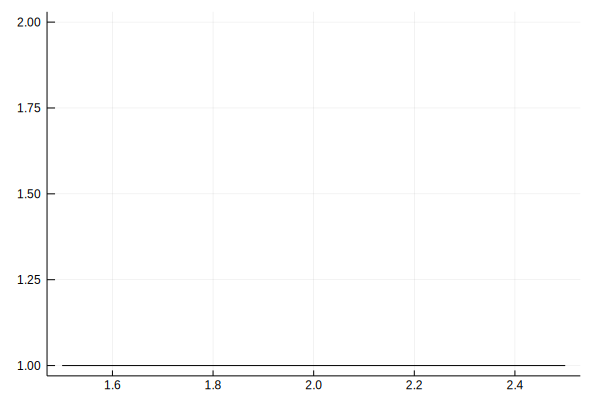

In [58]:
#plot(sol, xlab=L"x_1", ylab=L"x_2")
plot(X0, color="red")

In [12]:
using Polyhedra, CDDLib

In [18]:
@time begin
    sol = solve(TwoTank, options,
                BFFPSV18(:δ=>0.001),
                ConcreteDiscretePost())
end;

  0.032559 seconds (2.74 k allocations: 596.500 KiB)
